In [1]:
!pip install scikit-learn pandas numpy



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install fsspec



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

df = pd.read_csv("C://23ADR115//ML-Project//Dataset//city_day.csv")
df.head()



,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Delhi,2015-01-01,153.3,241.7,182.9,33.0,81.3,38.5,1.87,64.5,83.6,18.93,20.81,8.32,204.5,Severe
1,Mumbai,2015-01-01,70.5,312.7,195.0,42.0,122.5,31.5,7.22,83.8,108.0,2.01,19.41,2.86,60.9,Satisfactory
2,Chennai,2015-01-01,174.1,275.4,56.2,68.8,230.9,28.5,8.56,60.8,43.9,19.07,10.19,9.63,486.5,Severe
3,Kolkata,2015-01-01,477.2,543.9,14.1,76.4,225.9,45.6,2.41,42.1,171.1,9.31,11.65,9.39,174.4,Very Poor
4,Bangalore,2015-01-01,171.6,117.7,123.3,12.4,61.9,49.7,1.26,79.7,164.3,6.04,12.74,9.59,489.7,Good


In [24]:
# Canonical Preprocessing Cell
DATASET_PATH = "C://23ADR115//ML-Project//Dataset//city_day.csv"  # Centralized dataset path
print('Loading dataset from:', DATASET_PATH)
# Load dataframe
df = pd.read_csv(DATASET_PATH)
print('Initial shape:', df.shape)
print('Columns:', df.columns.tolist())

# If the dataset already contains 'AQI_Bucket' prefer it as target; otherwise bucketize numeric 'AQI'
if 'AQI_Bucket' in df.columns:
    target_name = 'AQI_Bucket'
elif 'AQI' in df.columns:
    target_name = 'AQI_Category'
else:
    raise ValueError('No AQI target found (AQI_Bucket or AQI) in dataset')

# If required, create AQI_Category from numeric AQI (only if AQI_Bucket not present)
if target_name == 'AQI_Category':
    df['AQI_Category'] = pd.cut(
        df['AQI'],
        bins=[0, 100, 200, 300, 400, 500],
        labels=[0, 1, 2, 3, 4]
    )
    df.dropna(subset=['AQI_Category'], inplace=True)
    df['AQI_Category'] = df['AQI_Category'].astype(int)
    print('Created AQI_Category from AQI; shape:', df.shape)

# Drop non-numeric columns safely (dates, City)
safe_drop = [c for c in ['City','Date','Datetime'] if c in df.columns]
# If target exists in the list, remove it from drop list
if target_name in safe_drop:
    safe_drop.remove(target_name)
print('Dropping columns if present:', safe_drop)
df = df.drop(safe_drop, axis=1)

# Detect any non-numeric columns left over and encode/convert them 
object_cols = df.select_dtypes(include=['object']).columns.tolist()
# Exclude a numeric target that accidentally remains string (safeguard)
object_cols = [c for c in object_cols if c != target_name]

from sklearn.preprocessing import LabelEncoder
le_dict = {}
for col in object_cols:
    print('Encoding column:', col)
    df[col] = df[col].fillna('Unknown').astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Ensure numeric index order and impute numeric columns only
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print('Numeric columns:', numeric_cols)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
# Keep other types (if any) aside; we'll use numeric_cols for imputation
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Build X,y while ensuring target is correct column name
if target_name == 'AQI_Bucket':
    X = df.drop('AQI_Bucket', axis=1)
    y = df['AQI_Bucket']
else:
    X = df.drop(['AQI', 'AQI_Category'], axis=1, errors='ignore')
    y = df['AQI_Category']
print('Final X shape, y length:', X.shape, len(y))

# Train-test split and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Expose features and target name so other cells and Streamlit can access them
FEATURE_NAMES = list(X.columns)
TARGET_NAME = target_name
print('FEATURE_NAMES length:', len(FEATURE_NAMES))

Loading dataset from: C://23ADR115//ML-Project//Dataset//city_day.csv
Initial shape: (18265, 16)
Columns: ['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']
Dropping columns if present: ['City', 'Datetime']
Numeric columns: ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI']
Final X shape, y length: (18265, 13) 18265
FEATURE_NAMES length: 13


In [13]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("C://23ADR115//ML-Project//Dataset//city_day.csv")

# Drop NON-NUMERIC columns safely
cols_to_drop = [col for col in ['City', 'Date', 'AQI_Bucket'] if col in df.columns]
# If Date is still an object type, drop it and other non-numeric columns except 'AQI'
object_cols = df.select_dtypes(include=['object', 'datetime']).columns.tolist()
object_cols_to_drop = [c for c in object_cols if c != 'AQI']
cols_to_drop = list(set(cols_to_drop + object_cols_to_drop))
df = df.drop(cols_to_drop, axis=1)

# Handle missing values with mean
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Create AQI target labels
df_imputed['AQI_Category'] = pd.cut(
    df_imputed['AQI'],
    bins=[0, 100, 200, 300, 400, 500],
    labels=[0, 1, 2, 3, 4],
)

df_imputed.dropna(subset=['AQI_Category'], inplace=True)
df_imputed['AQI_Category'] = df_imputed['AQI_Category'].astype(int)

# X & y
X = df_imputed.drop(['AQI', 'AQI_Category'], axis=1)
y = df_imputed['AQI_Category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing completed successfully!")

Preprocessing completed successfully!


In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

svm_preds = svm_model.predict(X_test_scaled)

print("🎯 SVM Accuracy:", accuracy_score(y_test, svm_preds))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, svm_preds))
print("\n📄 Classification Report:\n", classification_report(y_test, svm_preds))


🎯 SVM Accuracy: 0.17328223378045443

📊 Confusion Matrix:
 [[122  81 108 106 131  71]
 [ 99  86  90 108 129  77]
 [114  81  98  97 123  90]
 [112  81 121 114 105  87]
 [125  94  97  85 129  94]
 [108  98  91 101 116  84]]

📄 Classification Report:
               precision    recall  f1-score   support

        Good       0.18      0.20      0.19       619
    Moderate       0.17      0.15      0.15       589
        Poor       0.16      0.16      0.16       603
Satisfactory       0.19      0.18      0.19       620
      Severe       0.18      0.21      0.19       624
   Very Poor       0.17      0.14      0.15       598

    accuracy                           0.17      3653
   macro avg       0.17      0.17      0.17      3653
weighted avg       0.17      0.17      0.17      3653



In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Make predictions
nb_preds = nb_model.predict(X_test_scaled)

# Evaluate
print("🎯 Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, nb_preds))
print("\n📄 Classification Report:\n", classification_report(y_test, nb_preds))


🎯 Naive Bayes Accuracy: 0.20476320832192718

📊 Confusion Matrix:
 [[146 192  62 155 180]
 [133 187  57 138 185]
 [141 209  74 149 204]
 [131 189  72 145 173]
 [135 186  87 127 196]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.20      0.21       735
           1       0.19      0.27      0.22       700
           2       0.21      0.10      0.13       777
           3       0.20      0.20      0.20       710
           4       0.21      0.27      0.23       731

    accuracy                           0.20      3653
   macro avg       0.21      0.21      0.20      3653
weighted avg       0.21      0.20      0.20      3653



In [16]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Make predictions
dt_preds = dt_model.predict(X_test_scaled)

# Evaluate
print("🎯 Decision Tree Accuracy:", accuracy_score(y_test, dt_preds))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, dt_preds))
print("\n📄 Classification Report:\n", classification_report(y_test, dt_preds))


🎯 Decision Tree Accuracy: 0.20722693676430332

📊 Confusion Matrix:
 [[159 146 138 155 137]
 [129 143 136 142 150]
 [142 167 151 184 133]
 [133 151 140 150 136]
 [162 138 129 148 154]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.22      0.22       735
           1       0.19      0.20      0.20       700
           2       0.22      0.19      0.21       777
           3       0.19      0.21      0.20       710
           4       0.22      0.21      0.21       731

    accuracy                           0.21      3653
   macro avg       0.21      0.21      0.21      3653
weighted avg       0.21      0.21      0.21      3653



In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test_scaled)

# Evaluate
print("🎯 Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))
print("\n📄 Classification Report:\n", classification_report(y_test, rf_preds))

🎯 Random Forest Accuracy: 0.18724336162058583

📊 Confusion Matrix:
 [[158 151 139 154 133]
 [146 129 133 152 140]
 [142 172 150 158 155]
 [150 179 135 116 130]
 [167 154 121 158 131]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.21      0.21       735
           1       0.16      0.18      0.17       700
           2       0.22      0.19      0.21       777
           3       0.16      0.16      0.16       710
           4       0.19      0.18      0.18       731

    accuracy                           0.19      3653
   macro avg       0.19      0.19      0.19      3653
weighted avg       0.19      0.19      0.19      3653



In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

knn_preds = knn_model.predict(X_test_scaled)

print("🎯 KNN Accuracy:", accuracy_score(y_test, knn_preds))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, knn_preds))
print("\n📄 Classification Report:\n", classification_report(y_test, knn_preds))


🎯 KNN Accuracy: 0.19682452778538187

📊 Confusion Matrix:
 [[201 158 130 136 110]
 [187 153 142 107 111]
 [206 188 138 129 116]
 [187 189 121 129  84]
 [238 165 121 109  98]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.27      0.23       735
           1       0.18      0.22      0.20       700
           2       0.21      0.18      0.19       777
           3       0.21      0.18      0.20       710
           4       0.19      0.13      0.16       731

    accuracy                           0.20      3653
   macro avg       0.20      0.20      0.19      3653
weighted avg       0.20      0.20      0.19      3653



In [26]:
# Install LightGBM (only needed once)
!pip install lightgbm

# Imports
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train LightGBM Model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Predictions
lgb_preds = lgb_model.predict(X_test_scaled)

# Evaluation
print("🎯 LightGBM Accuracy:", accuracy_score(y_test, lgb_preds))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, lgb_preds))
print("\n📄 Classification Report:\n", classification_report(y_test, lgb_preds))



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3311
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 13
[LightGBM] [Info] Start training from score -1.775603
[LightGBM] [Info] Start training from score -1.824029
[LightGBM] [Info] Start training from score -1.800972
[LightGBM] [Info] Start training from score -1.774391
[LightGBM] [Info] Start training from score -1.766753
[LightGBM] [Info] Start training from score -1.810131
🎯 LightGBM Accuracy: 0.1708185053380783

📊 Confusion Matrix:
 [[ 91  92 100 117 112 107]
 [103  92 101 104 107  82]
 [ 97  89 100 102 132  83]
 [114  96  86 111 120  93]
 [ 92  83  93  91 131 134]
 [ 91  88 107 100 113  99]]

📄 Classification Report:
               precision    recall  f1-score   support

        Good       0.15      0.15      0.15       619
    Moderate       0.17   

In [8]:
!pip install xgboost
from xgboost import XGBClassifier

# Initialize and train the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
xgb_preds = xgb_model.predict(X_test_scaled)

# Evaluate
print("🎯 XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, xgb_preds))
print("\n📄 Classification Report:\n", classification_report(y_test, xgb_preds))



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:10:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🎯 XGBoost Accuracy: 0.19436079934300574

📊 Confusion Matrix:
 [[158 138 132 152 155]
 [138 125 135 152 150]
 [171 153 138 155 160]
 [120 163 146 139 142]
 [137 157 137 150 150]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.21      0.22       735
           1       0.17      0.18      0.17       700
           2       0.20      0.18      0.19       777
           3       0.19      0.20      0.19       710
           4       0.20      0.21      0.20       731

    accuracy                           0.19      3653
   macro avg       0.19      0.19      0.19      3653
weighted avg       0.19      0.19      0.19      3653

🎯 XGBoost Accuracy: 0.19436079934300574

📊 Confusion Matrix:
 [[158 138 132 152 155]
 [138 125 135 152 150]
 [171 153 138 155 160]
 [120 163 146 139 142]
 [137 157 137 150 150]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.21      0.22   

Training VotingClassifier on balanced training set...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3312
[LightGBM] [Info] Number of data points in the train set: 14982, number of used features: 13
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:21:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Ensemble Accuracy: 0.1694

📊 Confusion Matrix:
 [[101 111 114  91 100 102]
 [ 82 130 111  95  93  78]
 [107 115  85  87 102 107]
 [ 98  89 103 104 117 109]
 [ 95 111 114  83 108 113]
 [ 99 116 105  88  99  91]]

📄 Classification Report:
               precision    recall  f1-score   support

        Good       0.17      0.16      0.17       619
    Moderate       0.19      0.22      0.21       589
        Poor       0.13      0.14      0.14       603
Satisfactory       0.19      0.17      0.18       620
      Severe       0.17      0.17      0.17       624
   Very Poor       0.15      0.15      0.15       598

    accuracy                           0.17      3653
   macro avg       0.17      0.17      0.17      3653
weighted avg       0.17      0.17      0.17      3653



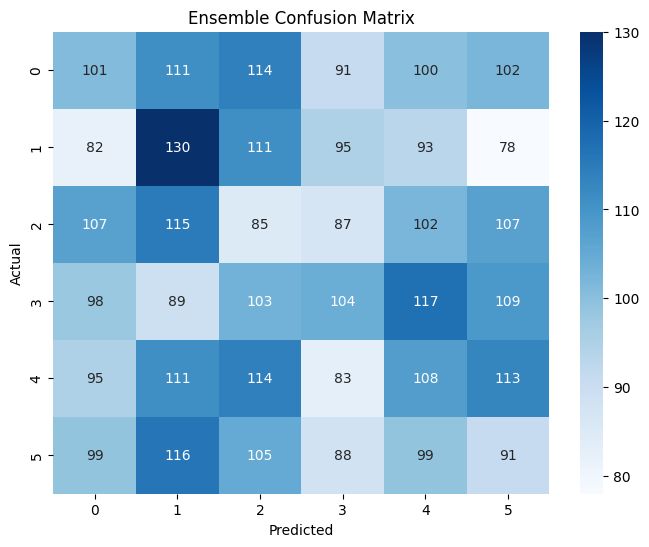

Saved VotingClassifier as: voting_ensemble_model.pkl

Top 10 feature importances for RandomForest:
 - AQI: 0.0787
 - PM10: 0.0781
 - PM2.5: 0.0781
 - Benzene: 0.0776
 - O3: 0.0771
 - NOx: 0.0768
 - SO2: 0.0768
 - NO2: 0.0767
 - Toluene: 0.0767
 - NO: 0.0765

Top 10 feature importances for LightGBM:
 - Toluene: 2929.0000
 - NH3: 2871.0000
 - NO2: 2859.0000
 - PM2.5: 2813.0000
 - O3: 2806.0000
 - CO: 2803.0000
 - Benzene: 2788.0000
 - AQI: 2750.0000
 - SO2: 2739.0000
 - NO: 2731.0000


In [29]:
# -----------------------------
# Canonical Ensemble: Voting Classifier (LightGBM, XGBoost, RandomForest)
# -----------------------------
# This cell uses the canonical pre-processing variables: X_train_scaled, X_test_scaled, y_train, y_test, and FEATURE_NAMES

# Ensure required imports
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Safety: if canonical variables are not present, try to run canonical preprocessing or raise a helpful error
try:
    X_train_scaled; X_test_scaled; y_train; y_test; FEATURE_NAMES
except NameError as e:
    raise NameError("Canonical preprocessing variables not found. Run the preprocessing cell first (the cell that creates X_train_scaled, X_test_scaled, y_train, y_test, and FEATURE_NAMES).")

# Balance classes using SMOTE on scaled training data (SMOTE expects 2D array)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Define models (clear parameterization; tune if needed later)
lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=10, random_state=42)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=10, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)

voting_clf = VotingClassifier(estimators=[('lgbm', lgbm), ('xgb', xgb), ('rf', rf)], voting='soft')

# Fit the ensemble on the balanced training set
print('Training VotingClassifier on balanced training set...')
voting_clf.fit(X_train_bal, y_train_bal)

# Predict on test set (scaled)
y_pred = voting_clf.predict(X_test_scaled)

# Evaluation: Accuracy, Confusion Matrix, Classification Report
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(f"✅ Ensemble Accuracy: {acc:.4f}\n")
print("📊 Confusion Matrix:\n", cm)
print("\n📄 Classification Report:\n", cr)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optional: Save the trained ensemble to disk for use by Streamlit or other apps
JOBLIB_NAME = 'voting_ensemble_model.pkl'
joblib.dump(voting_clf, JOBLIB_NAME)
print(f"Saved VotingClassifier as: {JOBLIB_NAME}")

# Feature importances from fitted estimators (if available)
fitted_estimators = getattr(voting_clf, 'named_estimators_', None)
rf_imp = None
lgb_imp = None
if fitted_estimators is not None:
    rf_est = fitted_estimators.get('rf', None)
    lgb_est = fitted_estimators.get('lgbm', None)
    if rf_est is not None and hasattr(rf_est, 'feature_importances_'):
        rf_imp = rf_est.feature_importances_
    if lgb_est is not None and hasattr(lgb_est, 'feature_importances_'):
        lgb_imp = lgb_est.feature_importances_

def print_top_imp(imp, feature_names, model_name):
    if imp is None:
        print(f"No importances found for {model_name}.")
        return
    imp = np.array(imp)
    top_idx = np.argsort(imp)[::-1][:10]
    print(f"\nTop 10 feature importances for {model_name}:")
    for i in top_idx:
        print(f" - {feature_names[i]}: {imp[i]:.4f}")

print_top_imp(rf_imp, FEATURE_NAMES, 'RandomForest')
print_top_imp(lgb_imp, FEATURE_NAMES, 'LightGBM')

c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, c

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3636
[LightGBM] [Info] Number of data points in the train set: 14046, number of used features: 15
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:20:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Ensemble Accuracy: 0.1640

📊 Confusion Matrix:
 [[126 109 156 131 135 117]
 [112 135 123 123 128 116]
 [125 152 128 117 108 124]
 [105 148 141 113 128 140]
 [134 122 131 119 121 153]
 [128 126 128 122 117 126]]

📄 Classification Report:
               precision    recall  f1-score   support

        Good       0.17      0.16      0.17       774
    Moderate       0.17      0.18      0.18       737
        Poor       0.16      0.17      0.16       754
Satisfactory       0.16      0.15      0.15       775
      Severe       0.16      0.16      0.16       780
   Very Poor       0.16      0.17      0.17       747

    accuracy                           0.16      4567
   macro avg       0.16      0.16      0.16      4567
weighted avg       0.16      0.16      0.16      4567



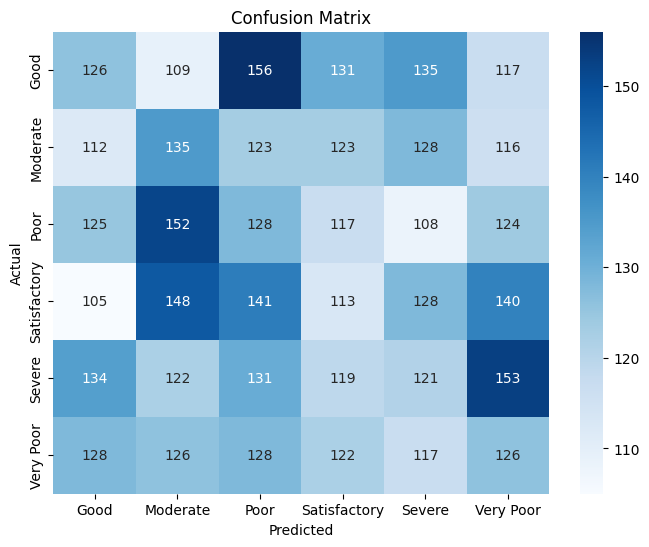

In [4]:
# ✅ Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load Dataset
df = pd.read_csv("C://23ADR115//ML-Project//Dataset//city_day.csv")

# ============================================================
# FIX 1: Handle missing values (EXCLUDE TARGET COLUMN)
# ============================================================
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'AQI_Bucket' in numeric_cols:
    numeric_cols.remove('AQI_Bucket')  # avoid converting target to float

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# ============================================================
# FIX 2: Label Encode target BEFORE filling
# ============================================================
le_target = LabelEncoder()
df['AQI_Bucket'] = le_target.fit_transform(df['AQI_Bucket'])

# ============================================================
# Encode Other Categorical Columns
# ============================================================
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Date']

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Drop date column if present
df = df.drop(['Date'], axis=1, errors='ignore')

# ============================================================
# Feature & Target Split
# ============================================================
X = df.drop('AQI_Bucket', axis=1)
y = df['AQI_Bucket']

# ============================================================
# Feature Scaling
# ============================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============================================================
# Train-Test Split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# ============================================================
# Apply SMOTE
# ============================================================
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# ============================================================
# Define Models
# ============================================================
lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=10,
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=10,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42
)

# ============================================================
# Ensemble Voting Classifier
# ============================================================
voting_clf = VotingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('xgb', xgb),
        ('rf', rf)
    ],
    voting='soft'
)

# ============================================================
# Fit Model
# ============================================================
voting_clf.fit(X_train_bal, y_train_bal)

# ============================================================
# Predict
# ============================================================
y_pred = voting_clf.predict(X_test)

# ============================================================
# Evaluate
# ============================================================
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# FIX 3: Convert class names to string to avoid TypeError
cr = classification_report(
    y_test,
    y_pred,
    target_names=[str(c) for c in le_target.classes_]
)

print(f"✅ Ensemble Accuracy: {acc:.4f}\n")
print("📊 Confusion Matrix:\n", cm)
print("\n📄 Classification Report:\n", cr)

# ============================================================
# Confusion Matrix Heatmap
# ============================================================
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le_target.classes_,
    yticklabels=le_target.classes_
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("C://23ADR115//ML-Project//Dataset//city_day.csv")  # updated path

# Drop unnecessary columns (if any)
if 'Date' in df.columns:
    df.drop('Date', axis=1, inplace=True)

# Handle missing values (numerical columns → mean)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Encode only object-type columns (categorical)
le_dict = {}
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna("Unknown")
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le

# Separate features and target
X = df.drop(['AQI_Bucket'], axis=1)
y = df['AQI_Bucket']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Helper function to evaluate models
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {name} Accuracy: {acc}\n")
    print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))

# 1. SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
evaluate_model("SVM", svm_model, X_test, y_test)

# 2. Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
evaluate_model("Naive Bayes", nb_model, X_test, y_test)

# 3. Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
evaluate_model("Decision Tree", dt_model, X_test, y_test)

# 4. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model("Random Forest", rf_model, X_test, y_test)

# 5. K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
evaluate_model("KNN", knn_model, X_test, y_test)

# 6. LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
evaluate_model("LightGBM", lgb_model, X_test, y_test)

# 7. XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_model, X_test, y_test)


🔍 SVM Accuracy: 0.17109225294278674

📊 Confusion Matrix:
 [[167   0  54 299  23  72]
 [171   0  58 247  37  72]
 [153   0  58 276  32  54]
 [165   0  54 296  26  69]
 [186   0  73 310  47  57]
 [160   0  54 297  29  57]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.27      0.21       615
           1       0.00      0.00      0.00       585
           2       0.17      0.10      0.13       573
           3       0.17      0.49      0.25       610
           4       0.24      0.07      0.11       673
           5       0.15      0.10      0.12       597

    accuracy                           0.17      3653
   macro avg       0.15      0.17      0.14      3653
weighted avg       0.15      0.17      0.14      3653


🔍 Naive Bayes Accuracy: 0.17300848617574596

📊 Confusion Matrix:
 [[134  72  77 129  97 106]
 [121  81  87 112  96  88]
 [127  83  98  89  98  78]
 [128  79  97 102  98 106]
 [156  86 112 111 118  90]
 [127 

c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av


🔍 Decision Tree Accuracy: 0.1667122912674514

📊 Confusion Matrix:
 [[ 98  88 108  98 122 101]
 [101  81  86 117  94 106]
 [ 99 105  86  96  97  90]
 [107 103  89 125  87  99]
 [114 107 114 119 115 104]
 [118  98  81 109  87 104]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.16      0.16       615
           1       0.14      0.14      0.14       585
           2       0.15      0.15      0.15       573
           3       0.19      0.20      0.20       610
           4       0.19      0.17      0.18       673
           5       0.17      0.17      0.17       597

    accuracy                           0.17      3653
   macro avg       0.17      0.17      0.17      3653
weighted avg       0.17      0.17      0.17      3653


🔍 Random Forest Accuracy: 0.15849986312619765

📊 Confusion Matrix:
 [[127 110 100  88 103  87]
 [129  74  98 113  83  88]
 [106  90  99 112  93  73]
 [124  80 118  99  89 100]
 [134 105 124 110 109 

c:\Users\Nandhini\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:14:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔍 XGBoost Accuracy: 0.16753353408157678

📊 Confusion Matrix:
 [[103  95 110 104  92 111]
 [115  99  89 116  93  73]
 [108  96  84  93 102  90]
 [ 87  99 116 118 100  90]
 [120  99 123 115 112 104]
 [ 95  90  86 128 102  96]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.17      0.17       615
           1       0.17      0.17      0.17       585
           2       0.14      0.15      0.14       573
           3       0.18      0.19      0.18       610
           4       0.19      0.17      0.18       673
           5       0.17      0.16      0.17       597

    accuracy                           0.17      3653
   macro avg       0.17      0.17      0.17      3653
weighted avg       0.17      0.17      0.17      3653



In [27]:
import joblib
joblib.dump(lgb_model , 'model.pkl')  # Save your trained model


['model.pkl']

In [30]:
!pip install streamlit
import streamlit as st
import numpy as np
import joblib
import pandas as pd

# Preferred model file produced by the ensemble cell
preferred_model_files = ['voting_ensemble_model.pkl', 'model.pkl', 'lgb_model.pkl']

# Pick the first model file that exists and load it
import os
model_path = None
for candidate in preferred_model_files:
    if os.path.exists(candidate):
        model_path = candidate
        break
if model_path is None:
    raise FileNotFoundError('No model artifact found. Run the model training cell to produce a model file (voting_ensemble_model.pkl).')
model = joblib.load(model_path)
print(f'Loaded model from: {model_path}')

st.title("🌫️ Air Quality Prediction")
st.write("Enter input features to predict the air quality category.")

# Determine feature names from pre-processing variables if available
try:
    feature_names = FEATURE_NAMES
except NameError:
    # Fall back to approximate names if canonical preprocess hasn't run or variable isn't in scope
    df = pd.read_csv("C://23ADR115//ML-Project//Dataset//city_day.csv")
    feature_names = [c for c in df.columns if c not in ['AQI_Bucket', 'AQI', 'City', 'Date', 'Datetime']]
    print('Using fallback feature names from dataframe')

inputs = []
for name in feature_names:
    val = st.number_input(f"Enter {name}", format="%.5f")
    inputs.append(val)

if st.button("Predict"):
    # Ensure correct shape and scaling
    x_input = np.array(inputs).reshape(1, -1)
    try:
        # Scale input if scaler exists from preprocessing step
        x_input_scaled = scaler.transform(x_input)
    except NameError:
        x_input_scaled = x_input
    # Check length match
    if x_input_scaled.shape[1] != len(feature_names):
        st.error(f"Feature length mismatch: expected {len(feature_names)} features, got {x_input_scaled.shape[1]}")
    else:
        pred = model.predict(x_input_scaled)
        # If prediction is array of strings or ints, display directly
        st.success(f"Predicted Air Quality Class: **{pred[0]}**")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
2025-12-01 21:21:56.312 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 21:21:56.313 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 21:21:56.313 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 21:21:56.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 21:21:56.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 21:21:56.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-01 21:21:56.316 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare m

Loaded model from: voting_ensemble_model.pkl


In [22]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# ============================
# 1. Load dataset
# ============================
df = pd.read_csv("C://23ADR115//ML-Project//Dataset//city_day.csv")

print("Columns in CSV:", df.columns.tolist())

# ============================
# 2. Drop NON-NUMERIC columns safely
# ============================
non_numeric_cols = ['City', 'Datetime', 'AQI_Bucket']   # use 'Datetime' here
cols_to_drop = [col for col in non_numeric_cols if col in df.columns]

df = df.drop(cols_to_drop, axis=1)
print("\nDropped columns:", cols_to_drop)

# ============================
# 3. Handle missing values (mean)
# ============================
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# ============================
# 4. Create AQI target labels
# ============================
df_imputed['AQI_Category'] = pd.cut(
    df_imputed['AQI'],
    bins=[0, 100, 200, 300, 400, 500],
    labels=[0, 1, 2, 3, 4],
)

df_imputed.dropna(subset=['AQI_Category'], inplace=True)
df_imputed['AQI_Category'] = df_imputed['AQI_Category'].astype(int)

# ============================
# 5. Feature & Target Split
# ============================
X = df_imputed.drop(['AQI', 'AQI_Category'], axis=1)
y = df_imputed['AQI_Category']

# ============================
# 6. Train-test split
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================
# 7. Scaling
# ============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nPreprocessing completed successfully!\n")

# ============================
# 8. MODELS
# ============================

# ------- KNN -------
print("======== KNN ========")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, knn_preds))
print(confusion_matrix(y_test, knn_preds))
print(classification_report(y_test, knn_preds))

# ------- Decision Tree -------
print("\n======== Decision Tree ========")
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
dt_preds = dt.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, dt_preds))
print(confusion_matrix(y_test, dt_preds))
print(classification_report(y_test, dt_preds))

# ------- SVM -------
print("\n======== SVM ========")
svm = SVC()
svm.fit(X_train_scaled, y_train)
svm_preds = svm.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, svm_preds))
print(confusion_matrix(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

# ------- Naive Bayes -------
print("\n======== Naive Bayes ========")
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
nb_preds = nb.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, nb_preds))
print(confusion_matrix(y_test, nb_preds))
print(classification_report(y_test, nb_preds))

# ------- Random Forest -------
print("\n======== Random Forest ========")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Columns in CSV: ['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']

Dropped columns: ['City', 'Datetime', 'AQI_Bucket']

Preprocessing completed successfully!

======== KNN ========
Accuracy: 0.19682452778538187
[[201 158 130 136 110]
 [187 153 142 107 111]
 [206 188 138 129 116]
 [187 189 121 129  84]
 [238 165 121 109  98]]
              precision    recall  f1-score   support

           0       0.20      0.27      0.23       735
           1       0.18      0.22      0.20       700
           2       0.21      0.18      0.19       777
           3       0.21      0.18      0.20       710
           4       0.19      0.13      0.16       731

    accuracy                           0.20      3653
   macro avg       0.20      0.20      0.19      3653
weighted avg       0.20      0.20      0.19      3653


======== Decision Tree ========
Accuracy: 0.19682452778538187
[[201 158 130 136 110]
 [187 153 1